<a href="https://colab.research.google.com/github/difinative/k8-performance-check/blob/main/Copy_of_NewEasyOCR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 17.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'GPU available: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')


GPU available: Tesla T4


GPU available: True
Attempt 1


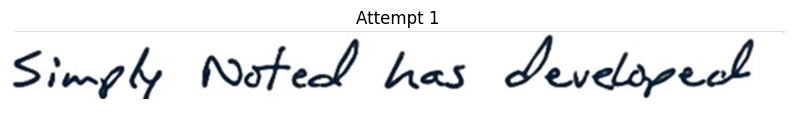

Detected text: Sinel (Confidence: 0.7793965782606697)
Detected text: Nofezb (Confidence: 0.19637136054459223)
Detected text: has (Confidence: 0.9625906986018036)
Detected text: Dvelspeel (Confidence: 0.1785080117071201)
Reference sentence not found in this attempt.

Attempt 2


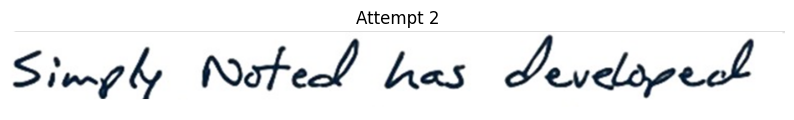

Detected text: Sinel (Confidence: 0.6515224182311377)
Detected text: Nofezb (Confidence: 0.19637136054459223)
Detected text: has (Confidence: 0.9625906986018036)
Detected text: Dvelspeel (Confidence: 0.1785080117071201)
Reference sentence not found in this attempt.

Attempt 3


KeyboardInterrupt: ignored

In [4]:
import easyocr
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Check for a GPU
gpu_available = torch.cuda.is_available()
print(f'GPU available: {gpu_available}')

# Function to display an image
def display_image(img, title="Image"):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to try OCR with different preprocessing and EasyOCR parameters
def ocr_with_preprocessing(image_path, reference_sentence):
    found = False
    attempt = 0
    total_attempts = 0

    # Define preprocessing methods
    def preprocess1(img): return img
    def preprocess2(img): return cv2.medianBlur(img, 3)
    def preprocess3(img): return cv2.GaussianBlur(img, (5, 5), 0)
    # ... add more preprocessing functions as needed

    preprocessing_methods = [preprocess1, preprocess2, preprocess3]  # add all your methods to this list

    # Define a range of EasyOCR parameters to try
    contrast_ths = [0.05, 0.1, 0.3]
    adjust_contrast = [0.7, 1, 1.3]
    text_threshold = [0.4, 0.6, 0.8]
    low_text = [0.4, 0.6, 0.8]
    link_threshold = [0.4, 0.6, 0.8]

    # Create combinations of all parameters
    from itertools import product
    parameter_combinations = list(product(preprocessing_methods, contrast_ths, adjust_contrast, text_threshold, low_text, link_threshold))

    # Cap the number of total attempts to 50
    parameter_combinations = parameter_combinations[:50]

    # Load the original image once
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"The image at path {image_path} does not exist.")

    # Loop over combinations of preprocessing methods and OCR parameters
    for preprocess, contrast_th, adjust_cont, text_thresh, low_txt, link_thresh in parameter_combinations:
        total_attempts += 1
        print(f"Attempt {total_attempts}")
        processed_img = preprocess(original_img)

        # Apply OCR with different parameters
        reader = easyocr.Reader(['en'], gpu=gpu_available)
        results = reader.readtext(processed_img,
                                  contrast_ths=contrast_th,
                                  adjust_contrast=adjust_cont,
                                  text_threshold=text_thresh,
                                  low_text=low_txt,
                                  link_threshold=link_thresh)

        # Display the image being processed
        display_image(processed_img, title=f"Attempt {total_attempts}")

        # Check results
        for (bbox, text, prob) in results:
            print(f"Detected text: {text} (Confidence: {prob})")
            if reference_sentence.lower() in text.lower():
                print(f"Found the sentence in attempt {total_attempts}!")
                found = True
                break

        if found:
            break
        else:
            print("Reference sentence not found in this attempt.\n")

    if not found:
        print("Failed to find the reference sentence after all attempts.")

# Define the reference sentence
reference_sentence = "Simply Notes has developed"

# Path to your image
image_path = '/content/drive/MyDrive/OCR/WriteLine1.png'

# Run OCR with preprocessing
ocr_with_preprocessing(image_path, reference_sentence)


In [ ]:
import cv2
import easyocr

class OCRService:
    def __init__(self, languages=['hi', 'en']):
        self.reader = easyocr.Reader(languages)

    def enhance_image(self, image_path):
        # Read the image using OpenCV
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Binary Thresholding
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        return thresh

    def recognize_text(self, image_path):
        try:
            enhanced_image = self.enhance_image(image_path)
            result = self.reader.readtext(enhanced_image)

            # If there's no detected text, inform the user
            if not result:
                print("No text detected in the image.")
                return

            # Sort the result based on the vertical position (y-coordinate) of the bounding box
            sorted_result = sorted(result, key=lambda detection: detection[0][0][1])

            # Extract and print the recognized text
            for detection in sorted_result:
                text = detection[1]
                print(text)

        except FileNotFoundError:
            print(f"Error: The file '{image_path}' was not found.")
        except Exception as e:
            print(f"An error occurred: {e}")

if __name__ == "__main__":
    ocr_service = OCRService()

    while True:
        image_path = input("Please input the image file path or type 'exit' to quit: ")

        if image_path.lower() == 'exit':
            break

        ocr_service.recognize_text(image_path)


In [ ]:
import easyocr
import cv2
import numpy as np
from matplotlib import pyplot as plt
from itertools import product
import torch

# Check for a GPU
gpu_available = torch.cuda.is_available()
print(f'GPU available: {gpu_available}')

# Function to display an image
def display_image(img, title="Image"):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to try OCR with different preprocessing and EasyOCR parameters
def ocr_with_preprocessing(image_path, reference_sentence, model_path):
    found = False
    total_attempts = 0

    # Define preprocessing methods
    # ... (define your preprocessing methods as in the previous code)

    preprocessing_methods = [lambda img: img]  # Add all preprocessing functions here

    # Define a range of EasyOCR parameters to try
    contrast_ths = [0.05, 0.1, 0.3]
    adjust_contrast = [0.7, 1, 1.3]
    # ... (add other parameters as in the previous code)

    # Create combinations of all parameters
    parameter_combinations = list(product(preprocessing_methods, contrast_ths, adjust_contrast))

    # Cap the number of total attempts to 50
    parameter_combinations = parameter_combinations[:50]

    # Load the original image once
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"The image at path {image_path} does not exist.")

    # Loop over combinations of preprocessing methods and OCR parameters
    for preprocess, contrast_th, adjust_cont in parameter_combinations:
        total_attempts += 1
        print(f"Attempt {total_attempts}")
        processed_img = preprocess(original_img)

        # Create a new EasyOCR reader instance with the custom model
        reader = easyocr.Reader(['en'], gpu=gpu_available, model_storage_directory=model_path, user_network_directory=model_path)
        results = reader.readtext(processed_img,
                                  contrast_ths=contrast_th,
                                  adjust_contrast=adjust_cont)

        # Display the image being processed
        display_image(processed_img, title=f"Attempt {total_attempts}")

        # Check results
        for (bbox, text, prob) in results:
            print(f"Detected text: {text} (Confidence: {prob})")
            if reference_sentence.lower() in text.lower():
                print(f"Found the sentence in attempt {total_attempts}!")
                found = True
                break

        if found:
            break
        else:
            print("Reference sentence not found in this attempt.\n")

    if not found:
        print("Failed to find the reference sentence after all attempts.")

# Define the reference sentence
reference_sentence = "Simply Notes has developed"

# Path to the new image
image_path = '/content/drive/MyDrive/OCR/1.jpg'

# Path to the custom model directory
model_path = '/content/drive/MyDrive/OCR/models'

# Run OCR with preprocessing
ocr_with_preprocessing(image_path, reference_sentence, model_path)


In [ ]:
import easyocr
import cv2
from IPython.display import Image, display
import torch

# Check for a GPU
gpu_available = torch.cuda.is_available()
print(f'GPU available: {gpu_available}')

# Function to add bounding boxes and text on an image
def draw_boxes_on_image(image_path, results):
    img = cv2.imread(image_path)
    for (bbox, text, prob) in results:
        # Draw the bounding box rectangle and add text
        top_left = tuple([int(val) for val in bbox[0]])
        bottom_right = tuple([int(val) for val in bbox[2]])
        img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)
        img = cv2.putText(img, text, (top_left[0], top_left[1] - 10),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    output_path = '/content/drive/MyDrive/OCR/result.jpg'
    cv2.imwrite(output_path, img)
    return output_path

# Function to perform OCR with one attempt and draw bounding boxes
def ocr_and_draw_boxes(image_path, model_path):
    # Load the original image
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"The image at path {image_path} does not exist.")

    reader = easyocr.Reader(['en'], gpu=gpu_available, model_storage_directory=model_path, user_network_directory=model_path)
    results = reader.readtext(original_img)

    # Now, we draw the results on the image
    output_image_path = draw_boxes_on_image(image_path, results)

    # Display the image with bounding boxes in Google Colab
    display(Image(output_image_path))

# Path to the new image
image_path = '/content/drive/MyDrive/OCR/1.jpg'

# Path to the custom model directory
model_path = '/content/drive/MyDrive/OCR/models'

# Perform OCR and draw bounding boxes
ocr_and_draw_boxes(image_path, model_path)


In [ ]:
import easyocr
import torch
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import yaml
import sys

# Custom paths
custom_model_path = '/content/drive/MyDrive/OCR/root/EasyOCR/model/custom_model.pth'
user_network_path = '/content/drive/MyDrive/OCR/root/EasyOCR/user_network'
custom_model_config_path = '/content/drive/MyDrive/OCR/root/EasyOCR/user_network/custom_model.yaml'

# Add the user_network_path to the sys.path so we can import the Model
sys.path.append(user_network_path)
from custom_model import Model

# Load the configuration for the custom model
with open(custom_model_config_path, 'r') as cfg_file:
    custom_model_config = yaml.safe_load(cfg_file)
    network_params = custom_model_config['network_params']
    num_class = len(custom_model_config['character_list']) + 1  # Including CTC blank character

# Initialize the custom model
custom_model = Model(
    input_channel=network_params['input_channel'],
    output_channel=network_params['output_channel'],
    hidden_size=network_params['hidden_size'],
    num_class=num_class
)

# Function to remove 'module.' prefix from state_dict keys
def remove_module_prefix(state_dict):
    return {k.replace('module.', ''): v for k, v in state_dict.items()}

# Load the trained weights with correction for 'module.' prefix
checkpoint = torch.load(custom_model_path, map_location=torch.device('cpu'))
corrected_state_dict = remove_module_prefix(checkpoint)
custom_model.load_state_dict(corrected_state_dict)
custom_model.eval()  # Set the model to evaluation mode

# Load EasyOCR reader for English
reader = easyocr.Reader(['en'])

# Define image pre-processing for the custom model
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((custom_model_config['imgH'], custom_model_config['imgH'] * 4)),  # Aspect ratio 1:4 as common in text
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Function to preprocess and predict with the custom model
def predict_custom_model(image_path, model, device='cpu'):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    with torch.no_grad():
        preds = model(image, text=None)
        preds = torch.nn.functional.log_softmax(preds, dim=2)
        preds = preds.permute(1, 0, 2)
        preds_max_prob, preds_index = preds.max(dim=2)

    preds_index = preds_index.transpose(1, 0).contiguous().view(-1)
    preds_max_prob = preds_max_prob.transpose(1, 0).contiguous().view(-1)
    pred_texts = ''.join([custom_model_config['character_list'][i] for i in preds_index if i < len(custom_model_config['character_list'])])
    pred_confidences = [float(prob) for prob in preds_max_prob]

    return pred_texts, pred_confidences

# Function to visualize the predictions
def visualize_predictions(image_path, ocr_results, custom_word):
    # Open an image file
    image = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(image)

    # Load a font
    font_size = 20
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    # Draw the EasyOCR results
    for bbox, text, _ in ocr_results:
        # Each bbox is a quadrilateral vertices in the order of top-left, top-right, bottom-right, bottom-left.
        draw.polygon(bbox, outline='green')
        text_size = font.getsize(text)
        draw.rectangle([bbox[0], (bbox[0][0] + text_size[0], bbox[0][1] - text_size[1])], fill='green')
        draw.text((bbox[0][0], bbox[0][1] - text_size[1]), text, fill='red', font=font)

    # Since your custom model might not return bounding boxes, we don't draw them here
    # Instead, let's just print the custom word
    print("Custom word detected by custom model:")
    print(custom_word)

    # Show the image
    image.show()

    # Save the image with bounding boxes and text
    image.save('/content/drive/MyDrive/OCR/result.jpg')

# Example usage:
image_path = '/content/drive/MyDrive/OCR/1.jpg'

# Detect text using EasyOCR
easyocr_results = reader.readtext(image_path)

# Detect custom words using your custom model
custom_word, custom_confidences = predict_custom_model(image_path, custom_model)

# Print the results from EasyOCR
print("Results from EasyOCR:")
for result in easyocr_results:
    print(f"Detected text: {result[1]} with confidence {result[2]:.2f}")

# Visualize the results
visualize_predictions(image_path, easyocr_results, custom_word)


In [ ]:
cp /content/drive/MyDrive/OCR/root/EasyOCR/user_network/custom_model.yaml /root/.EasyOCR//user_network/custom_model.yaml

In [ ]:
cp /content/drive/MyDrive/OCR/root/EasyOCR/user_network/custom_model.py /root/.EasyOCR//user_network/custom_model.py

In [ ]:
cp /content/drive/MyDrive/OCR/root/EasyOCR/model/custom_model.pth /root/.EasyOCR//model/custom_model.pth

In [ ]:
import easyocr
import torch
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import yaml
import sys

# Custom paths
custom_model_path = '/content/drive/MyDrive/OCR/root/EasyOCR/model/custom_model.pth'
user_network_path = '/content/drive/MyDrive/OCR/root/EasyOCR/user_network'
custom_model_config_path = '/content/drive/MyDrive/OCR/root/EasyOCR/user_network/custom_model.yaml'

# Add the user_network_path to the sys.path so we can import the Model
sys.path.append(user_network_path)
from custom_model import Model

# Load the configuration for the custom model
with open(custom_model_config_path, 'r') as cfg_file:
    custom_model_config = yaml.safe_load(cfg_file)
    network_params = custom_model_config['network_params']
    num_class = len(custom_model_config['character_list']) + 1  # Including CTC blank character

# Initialize the custom model
custom_model = Model(
    input_channel=network_params['input_channel'],
    output_channel=network_params['output_channel'],
    hidden_size=network_params['hidden_size'],
    num_class=num_class
)

# Function to remove 'module.' prefix from state_dict keys
def remove_module_prefix(state_dict):
    return {k.replace('module.', ''): v for k, v in state_dict.items()}

# Load the trained weights with correction for 'module.' prefix
checkpoint = torch.load(custom_model_path, map_location=torch.device('cpu'))
corrected_state_dict = remove_module_prefix(checkpoint)
custom_model.load_state_dict(corrected_state_dict)
custom_model.eval()  # Set the model to evaluation mode

# Load EasyOCR reader for English
reader = easyocr.Reader(['en'])

# Define image pre-processing for the custom model
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((custom_model_config['imgH'], custom_model_config['imgH'] * 4)),  # Aspect ratio 1:4 as common in text
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Function to preprocess and predict with the custom model
def predict_custom_model(image_path, model, device='cpu'):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    with torch.no_grad():
        preds = model(image, text=None)
        preds = torch.nn.functional.log_softmax(preds, dim=2)
        preds = preds.permute(1, 0, 2)
        preds_max_prob, preds_index = preds.max(dim=2)

    preds_index = preds_index.transpose(1, 0).contiguous().view(-1)
    preds_max_prob = preds_max_prob.transpose(1, 0).contiguous().view(-1)
    pred_texts = ''.join([custom_model_config['character_list'][i] for i in preds_index if i < len(custom_model_config['character_list'])])
    pred_confidences = [float(prob) for prob in preds_max_prob]

    return pred_texts, pred_confidences

import cv2
import numpy as np
from matplotlib import pyplot as plt

# Function to visualize the predictions using OpenCV
def visualize_predictions_opencv(image_path, ocr_results, custom_word):
    # Open an image file with OpenCV
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Define font scale and thickness
    font_scale = 0.5  # Adjust the font size to your preference
    thickness = 2     # Adjust the text thickness to your preference

    # Draw the EasyOCR results
    for bbox, text, _ in ocr_results:
        # EasyOCR bbox format: top-left, top-right, bottom-right, bottom-left
        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))

        # Draw the bounding box
        img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), )  # Green bounding box

        # Calculate the position for the text
        # Use getTextSize to get the width and height of the text box
        (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)

        # Position text closer to the bounding box
        # Decrease the gap by reducing the amount subtracted from top_left[1]
        text_position = (top_left[0], top_left[1] - text_height // 2)  # Adjust vertical position

        # Draw the text
        img = cv2.putText(img, text, text_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 0), thickness)  # Red text

    # Display the image with bounding boxes and text using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Save the image with bounding boxes and text
    cv2.imwrite('/content/drive/MyDrive/OCR/result.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Convert back to BGR before saving

# Example usage:
image_path = '/content/drive/MyDrive/OCR/18th Oct, 2023.jpeg'

# Detect text using EasyOCR
easyocr_results = reader.readtext(image_path)

# Detect custom words using your custom model
custom_word, custom_confidences = predict_custom_model(image_path, custom_model)

# Print the results from EasyOCR
print("Results from EasyOCR:")
for result in easyocr_results:
    print(f"Detected text: {result[1]} with confidence {result[2]:.2f}")

# Visualize the results using OpenCV
visualize_predictions_opencv(image_path, easyocr_results, custom_word)


In [ ]:
!pip install easyocr

In [ ]:
import easyocr
import torch
from torchvision import transforms
from PIL import Image
import yaml
import sys
import difflib
import cv2
from matplotlib import pyplot as plt

# Define your custom vocabulary list
custom_vocabulary = ['FABT', 'MABT', 'CPVC',  ' PVC', 'Bombay', 'Elbow', 'R.Tee', 'Tee', 'NRV', 'Nipple', 'Pipe', 'Elbow', 'Nos', 'mm', 'Clamp', '1.Nos']

# Function to correct to custom vocabulary
def correct_to_custom_vocabulary(text, vocabulary):
    """
    Corrects the given text to the closest match in the custom vocabulary.
    """
    closest_match = difflib.get_close_matches(text.upper(), vocabulary, n=1, cutoff=0.5)
    return closest_match[0] if closest_match else text

# Custom paths
custom_model_path = '/content/drive/MyDrive/OCR/root/EasyOCR/model/custom_model.pth'
#custom_model_path = '/content/drive/MyDrive/OCR/EasyOCR_Model2.pth'

user_network_path = '/content/drive/MyDrive/OCR/root/EasyOCR/user_network'
custom_model_config_path = '/content/drive/MyDrive/OCR/root/EasyOCR/user_network/custom_model.yaml'

# Add the user_network_path to the sys.path so we can import the Model
sys.path.append(user_network_path)
from custom_model import Model

# Load the configuration for the custom model
with open(custom_model_config_path, 'r') as cfg_file:
    custom_model_config = yaml.safe_load(cfg_file)
    network_params = custom_model_config['network_params']
    num_class = len(custom_model_config['character_list']) + 1  # Including CTC blank character

# Initialize the custom model
custom_model = Model(
    input_channel=network_params['input_channel'],
    output_channel=network_params['output_channel'],
    hidden_size=network_params['hidden_size'],
    num_class=num_class
)

# Function to remove 'module.' prefix from state_dict keys
def remove_module_prefix(state_dict):
    return {k.replace('module.', ''): v for k, v in state_dict.items()}

# Load the trained weights with correction for 'module.' prefix
checkpoint = torch.load(custom_model_path, map_location=torch.device('cpu'))
corrected_state_dict = remove_module_prefix(checkpoint)
custom_model.load_state_dict(corrected_state_dict)
custom_model.eval()  # Set the model to evaluation mode

# Load EasyOCR reader for English
reader = easyocr.Reader(['en'])

# Define image pre-processing for the custom model
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((custom_model_config['imgH'], custom_model_config['imgH'] * 4)),  # Aspect ratio 1:4 as common in text
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Function to preprocess and predict with the custom model
def predict_custom_model(image_path, model, device='cpu'):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    with torch.no_grad():
        preds = model(image, text=None)
        preds = torch.nn.functional.log_softmax(preds, dim=2)
        preds = preds.permute(1, 0, 2)
        preds_max_prob, preds_index = preds.max(dim=2)

    preds_index = preds_index.transpose(1, 0).contiguous().view(-1)
    preds_max_prob = preds_max_prob.transpose(1, 0).contiguous().view(-1)
    pred_texts = ''.join([custom_model_config['character_list'][i] for i in preds_index if i < len(custom_model_config['character_list'])])
    pred_confidences = [float(prob) for prob in preds_max_prob]

    return pred_texts, pred_confidences

# Function to visualize the predictions using OpenCV
def visualize_predictions_opencv(image_path, ocr_results, custom_vocabulary):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for bbox, text, confidence in ocr_results:
        # Correct the text to the closest word in the custom vocabulary
        corrected_text = correct_to_custom_vocabulary(text, custom_vocabulary)

        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))
        img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)

        font_scale = 0.5
        thickness = 2
        text_size, _ = cv2.getTextSize(corrected_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
        text_position = (top_left[0], top_left[1] - 10)

        img = cv2.putText(img, corrected_text, text_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 0), thickness)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    cv2.imwrite('/content/drive/MyDrive/OCR/result.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Example usage:
image_path = '/content/drive/MyDrive/OCR/PR.jpeg'

# Detect text using EasyOCR
easyocr_results = reader.readtext(image_path)

# Detect custom words using your custom model
custom_word, custom_confidences = predict_custom_model(image_path, custom_model)

# Correct OCR results to custom vocabulary
corrected_ocr_results = [
    (bbox, correct_to_custom_vocabulary(text, custom_vocabulary), confidence)
    for bbox, text, confidence in easyocr_results
]

# Visualize the results using OpenCV
visualize_predictions_opencv(image_path, corrected_ocr_results, custom_vocabulary)

# Print the corrected OCR results
print("Corrected OCR Results:")
for bbox, text, confidence in corrected_ocr_results:
    print(f"Detected text: {text} with confidence {confidence}")


In [ ]:
import easyocr
import torch
from torchvision import transforms
from PIL import Image
import yaml
import sys
import difflib
import cv2
from matplotlib import pyplot as plt

# Define your custom vocabulary list of phrases
custom_vocabulary_phrases = [
    '3/4 CPVC Pipe',
    '3/4 clamp',
    '3/4 CPVC Elbow',
    'CPVC Solvent'
    # ... Add more custom phrases as needed ...
]

# Function to correct to custom vocabulary phrases
def correct_to_custom_vocabulary_phrases(text_list, vocabulary_phrases):
    corrected_phrases = []
    i = 0
    while i < len(text_list):
        # Look ahead for three-word phrases
        if i <= len(text_list) - 3:
            three_word_phrase = ' '.join(text_list[i:i+3])
            if three_word_phrase in vocabulary_phrases:
                corrected_phrases.append(three_word_phrase)
                i += 3  # Skip the next two words
                continue
        corrected_phrases.append(text_list[i])
        i += 1
    return corrected_phrases

# Custom paths
custom_model_path = '/content/drive/MyDrive/OCR/root/EasyOCR/model/custom_model.pth'
user_network_path = '/content/drive/MyDrive/OCR/root/EasyOCR/user_network'
custom_model_config_path = '/content/drive/MyDrive/OCR/root/EasyOCR/user_network/custom_model.yaml'

# Add the user_network_path to the sys.path so we can import the Model
sys.path.append(user_network_path)
from custom_model import Model

# Load the configuration for the custom model
with open(custom_model_config_path, 'r') as cfg_file:
    custom_model_config = yaml.safe_load(cfg_file)
    network_params = custom_model_config['network_params']
    num_class = len(custom_model_config['character_list']) + 1  # Including CTC blank character

# Initialize the custom model
custom_model = Model(
    input_channel=network_params['input_channel'],
    output_channel=network_params['output_channel'],
    hidden_size=network_params['hidden_size'],
    num_class=num_class
)

# Function to remove 'module.' prefix from state_dict keys
def remove_module_prefix(state_dict):
    return {k.replace('module.', ''): v for k, v in state_dict.items()}

# Load the trained weights with correction for 'module.' prefix
checkpoint = torch.load(custom_model_path, map_location=torch.device('cpu'))
corrected_state_dict = remove_module_prefix(checkpoint)
custom_model.load_state_dict(corrected_state_dict)
custom_model.eval()  # Set the model to evaluation mode

# Load EasyOCR reader for English
reader = easyocr.Reader(['en'])

# Example usage:
image_path = '/content/drive/MyDrive/OCR/2.jpg'

# Detect text using EasyOCR
easyocr_results = reader.readtext(image_path)

# Flatten the OCR output into a list of words
ocr_words = [text for _, text, _ in easyocr_results]

# Apply the custom vocabulary phrase correction
corrected_text_list = correct_to_custom_vocabulary_phrases(ocr_words, custom_vocabulary_phrases)

# Rebuild the OCR results with corrected text
corrected_ocr_results = []
i = 0  # Index for the original OCR data list
j = 0  # Index for the corrected text list

while i < len(easyocr_results) and j < len(corrected_text_list):
    bbox, _, conf = easyocr_results[i]
    corrected_text = corrected_text_list[j]
    words_in_phrase = len(corrected_text.split())

    if words_in_phrase > 1:
        # This is a phrase. Combine the bounding boxes if needed, here we just take the first bbox for simplicity
        corrected_ocr_results.append((bbox, corrected_text, conf))
        i += words_in_phrase  # Skip the bounding boxes for the rest of the words in the phrase
    else:
        # This is a single word
        corrected_ocr_results.append((bbox, corrected_text, conf))
        i += 1

    j += 1  # Move to the next phrase or word in the corrected list

# Function to visualize the predictions using OpenCV
def visualize_predictions_opencv(image_path, ocr_results):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for bbox, text, _ in ocr_results:
        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))
        img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)

        font_scale = 0.5
        thickness = 2
        text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
        text_position = (top_left[0], top_left[1] - 10)

        img = cv2.putText(img, text, text_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 0), thickness)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    cv2.imwrite('/content/drive/MyDrive/OCR/result.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Visualize the results using OpenCV
visualize_predictions_opencv(image_path, corrected_ocr_results)

# Print the corrected OCR results
print("Corrected OCR Results:")
for bbox, text, confidence in corrected_ocr_results:
    print(f"Detected text: {text} with confidence {confidence}")


In [ ]:
# Step 1: Mount Google Drive to access the image
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install PaddleOCR and its dependencies
!pip install paddlepaddle paddleocr

# Step 3: Import PaddleOCR and run it on the image
from paddleocr import PaddleOCR, draw_ocr

# Create an OCR object
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Running OCR on the image in Google Drive
image_path = '/content/drive/MyDrive/OCR/2.jpg'
result = ocr.ocr(image_path, cls=True)

# Step 4: Extract the boxes, texts, and scores from the result
boxes = [line[0] for line in result]  # boxes
texts = [line[1][0] for line in result]  # texts
scores = [line[1][1] for line in result]  # scores

# Step 5: Draw the OCR result on the image
from PIL import Image

# Load the image
image = Image.open(image_path).convert('RGB')

# Draw the annotations on the image
# As of the current PaddleOCR version, draw_ocr function does not need font_path to be specified
annotated_image = draw_ocr(image, boxes, texts, scores)

# Save the result
annotated_image.save('/content/drive/MyDrive/OCR/result.jpg')

# Display the result
import IPython.display as display
display.display(annotated_image)


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import sys
import yaml
from collections import OrderedDict

# Assuming that custom_model.py is in the user_network directory
# and it contains the Model class with the correct architecture.
sys.path.append('/content/drive/MyDrive/OCR/root/EasyOCR/user_network')
from custom_model import Model

# Load the configuration for the custom model
custom_model_config_path = '/content/drive/MyDrive/OCR/root/EasyOCR/user_network/custom_model.yaml'
with open(custom_model_config_path, 'r') as cfg_file:
    custom_model_config = yaml.safe_load(cfg_file)

# Initialize the custom model with the number of classes plus one for the CTC blank character
num_classes = len(custom_model_config['character_list']) + 1
custom_model = Model(
    input_channel=custom_model_config['network_params']['input_channel'],
    output_channel=custom_model_config['network_params']['output_channel'],
    hidden_size=custom_model_config['network_params']['hidden_size'],
    num_class=num_classes
)

# Load the trained weights into the custom model
custom_model_path = '/content/drive/MyDrive/OCR/root/EasyOCR/model/custom_model.pth'
checkpoint = torch.load(custom_model_path, map_location='cpu')

# Check for DataParallel prefix and handle it
if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint

# Remove 'module.' prefix from state_dict keys if present
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] if k.startswith('module.') else k
    new_state_dict[name] = v

custom_model.load_state_dict(new_state_dict)
custom_model.eval()  # Set the model to evaluation mode

# Define image pre-processing
# Make sure that 'imgH' and 'imgW' are present in your custom_model_config
img_height = custom_model_config.get('imgH', 32)  # Provide default value if not present
img_width = custom_model_config.get('imgW', 128)  # Provide default value if not present

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define the function for CTC decoding
def ctc_decode(logits, char_list, blank_index=0):
    # Apply softmax to get probabilities
    probs = torch.nn.functional.softmax(logits, dim=2)
    _, indices = probs.max(dim=2)
    indices = indices.view(-1).tolist()

    # Decoding loop
    raw_output = []
    collapse_output = []
    prev_idx = None
    for idx in indices:
        if idx != prev_idx:  # Skip duplicates
            raw_output.append(char_list[idx] if idx != blank_index else '-')
        if idx != prev_idx and idx != blank_index:  # Skip blanks and duplicates
            collapse_output.append(char_list[idx])
        prev_idx = idx

    raw_text = ''.join(raw_output)
    collapse_text = ''.join(collapse_output).replace('-', '')  # Assuming '-' is the blank character
    return raw_text, collapse_text

# Define the function to preprocess and predict with the custom model
def predict_custom_model(image_path, model, transform, device='cpu', char_list=None):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        logits = model(image)

    print(f"Logits Size: {logits.size()}")  # Print the size of logits for debugging
    raw_output, collapse_output = ctc_decode(logits, char_list)

    return raw_output, collapse_output, logits  # Return logits for further analysis if needed


# Use the custom model to make a prediction on an image
image_path = '/content/drive/MyDrive/OCR/1.jpg'
raw_text, collapse_text, logits = predict_custom_model(
    image_path, custom_model, transform, device='cpu', char_list=custom_model_config['character_list']
)

# Print the CTC decoding stages
print(f"Input (raw CTC output): {raw_text}")
print(f"Collapse Repeats and Remove Blanks: {collapse_text}")

In [ ]:
# Import necessary libraries
import easyocr
import cv2
from matplotlib import pyplot as plt

# Define the path to the image file
image_path = '/content/drive/MyDrive/OCR/1.jpg'

# Initialize the easyocr Reader
reader = easyocr.Reader(['en'])

# Read the image and perform OCR
image = cv2.imread(image_path)
results = reader.readtext(image)

# Print the detected characters and CTC transcription
print("Detected Characters:")
for detection in results:
    text = detection[1]
    print(text)

# Display the intermediate layer of CTC transcription
for detection in results:
    text = detection[1]
    if len(detection) >= 3:
        prob = detection[2]
        print(f"Text: {text}")
        print(f"CTC Transcription:")
        print(prob)
        print("=" * 30)

# Display the image with bounding boxes
for detection in results:
    box = detection[0]
    top_left = tuple(map(int, (box[0][0], box[0][1])))
    bottom_right = tuple(map(int, (box[2][0], box[2][1])))

    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    cv2.putText(image, detection[1], (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Show the image with bounding boxes
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
!pip install easyocr
!pip install opencv-python-headless # Use opencv-python instead if you are not in a headless environment


In [ ]:
!pip install easyocr==2.0.0

In [ ]:
import easyocr
import cv2
import os

# Define paths
user_network_directory = '/content/drive/MyDrive/OCR/root/EasyOCR/user_network'
image_path = '/content/drive/MyDrive/OCR/1.jpg'
output_path = '/content/drive/MyDrive/OCR/result.jpg'

# Check if the custom model directory exists
if not os.path.isdir(user_network_directory):
    raise FileNotFoundError(f"The custom model directory {user_network_directory} was not found.")

print(f"Custom model directory found at: {user_network_directory}")

# Check if the image file exists
if not os.path.isfile(image_path):
    raise FileNotFoundError(f"The image file {image_path} was not found.")

print(f"Image file found at: {image_path}")

# Create a reader with the custom recognition model.
reader = easyocr.Reader(['en'], user_network_directory=user_network_directory)

print("Custom recognition model loaded successfully.")

# Read the image.
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Unable to read the image from the path {image_path}.")

print("Image read successfully.")

# Perform OCR on the image.
results = reader.readtext(image)

# Draw bounding boxes and text on the image.
for (bbox, text, prob) in results:
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = (int(top_left[0]), int(top_left[1]))
    bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

    # Draw a rectangle on the image.
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

    # Put the OCR'd text above the detected bounding box.
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_size = cv2.getTextSize(text, font, 0.5, 2)[0]
    text_x = top_left[0]
    text_y = top_left[1] - 10 if top_left[1] - 10 > text_size[1] else bottom_right[1] + text_size[1]
    cv2.putText(image, text, (text_x, text_y), font, 0.5, (0, 0, 255), 2)

# Save the result.
cv2.imwrite(output_path, image)

print(f"OCR process completed. Output image saved at: {output_path}")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import easyocr
import cv2
import os
from google.colab.patches import cv2_imshow

# Define paths
image_path = '/content/drive/MyDrive/OCR/1.jpg'

# Check if the image file exists
if not os.path.isfile(image_path):
    raise FileNotFoundError(f"The image file {image_path} was not found.")

print(f"Image file found at: {image_path}")

# Create a reader with the default recognition model for English.
reader = easyocr.Reader(['en'])

print("Default recognition model loaded successfully for English.")

# Read the image.
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Unable to read the image from the path {image_path}.")

print("Image read successfully.")

# Perform OCR on the image.
results = reader.readtext(image)

# Print bounding box coordinates and words detected, and display the extracted image patches
for i, (bbox, text, prob) in enumerate(results):
    # Convert bounding box coordinates to integers
    bbox = [(int(x), int(y)) for x, y in bbox]

    # Print the data as text
    print(f"Word {i + 1}:")
    print(f"Bounding Box Coordinates: {bbox}")
    print(f"Word Detected: {text}")
    print()

    # Extract the image patch within the bounding box
    x1, y1 = bbox[0]
    x2, y2 = bbox[2]
    patch = image[y1:y2, x1:x2]

    # Display the extracted image patch using cv2_imshow
    cv2_imshow(patch)

print("OCR process completed.")


In [ ]:
#november 9th with patch feature vectors
import easyocr
import cv2
import os
import torch
import torchvision.transforms as transforms
from torch import nn
from torchvision import models
from google.colab.patches import cv2_imshow

# Define paths
image_path = '/content/drive/MyDrive/OCR/IMG-20230902-WA0043.jpg'

# Check if the image file exists
if not os.path.isfile(image_path):
    raise FileNotFoundError(f"The image file {image_path} was not found.")

print(f"Image file found at: {image_path}")

# Create a reader with the default recognition model for English.
reader = easyocr.Reader(['en'])

print("Default recognition model loaded successfully for English.")

# Read the image.
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Unable to read the image from the path {image_path}.")

print("Image read successfully.")

# Initialize the ResNet model and load pre-trained weights.
resnet = models.resnet50(pretrained=True)
# Remove the final classification layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()  # Set the model to evaluation mode

# Define a transformation to preprocess the image for ResNet
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Perform OCR on the image.
results = reader.readtext(image)

# Print bounding box coordinates and words detected, and display the extracted image patches
for i, (bbox, text, prob) in enumerate(results):
    # Convert bounding box coordinates to integers
    bbox = [(int(x), int(y)) for x, y in bbox]

    # Print the data as text
    print(f"Word {i + 1}:")
    print(f"Bounding Box Coordinates: {bbox}")
    print(f"Word Detected: {text}")

    # Extract the image patch within the bounding box
    x1, y1 = bbox[0]
    x2, y2 = bbox[2]
    patch = image[y1:y2, x1:x2]

    # Display the extracted image patch using cv2_imshow
    cv2_imshow(patch)

    # Preprocess the patch for ResNet
    patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    patch = preprocess(patch)
    patch = patch.unsqueeze(0)  # Add batch dimension

    # Extract features from the last but one layer of ResNet
    with torch.no_grad():
        features = resnet(patch)

    # Print the extracted feature vector
    print(f"Feature Vector: {features.squeeze().tolist()}")
    print()

print("OCR process completed.")


processing with restnet

Image file found at: /content/drive/MyDrive/OCR/18th Oct, 2023.jpeg


<ipython-input-39-a69d68c27c46>:117: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = pil_image.resize((224, 224), Image.ANTIALIAS)


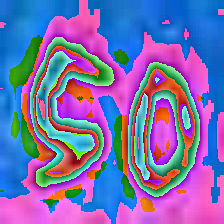

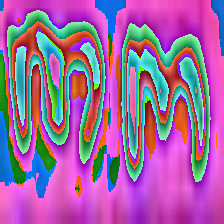

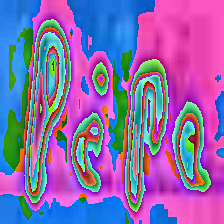

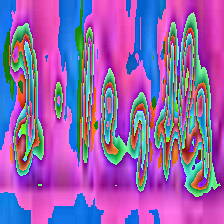

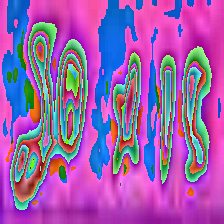

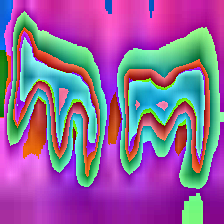

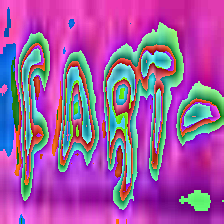

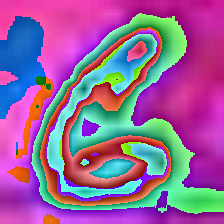

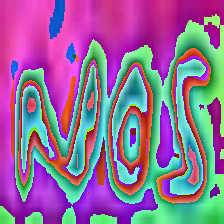

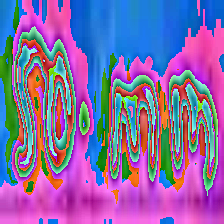

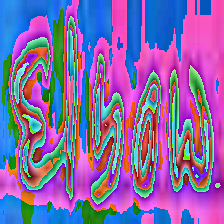

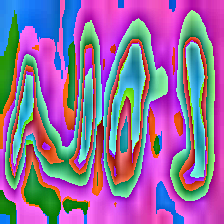

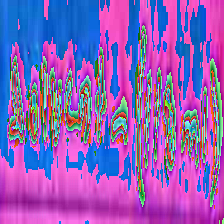

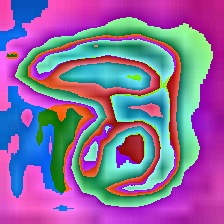

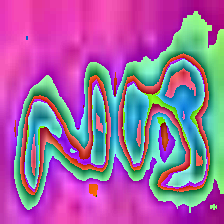

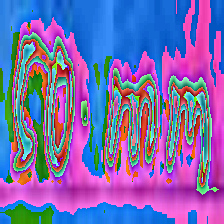

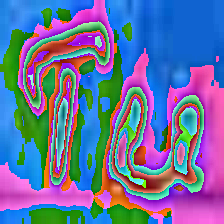

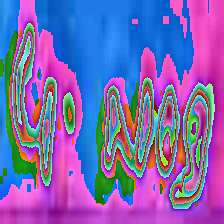

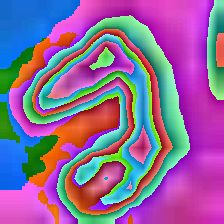

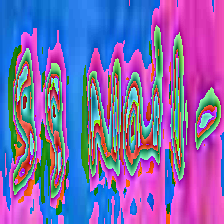

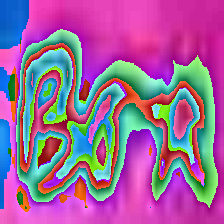

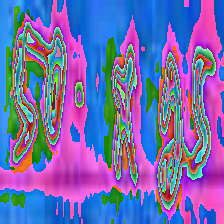

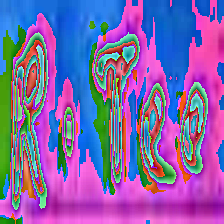

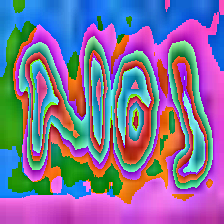

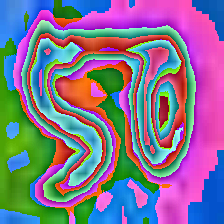

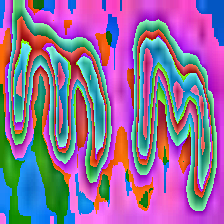

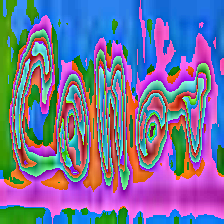

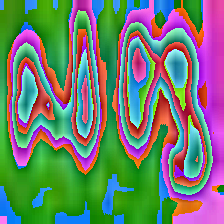

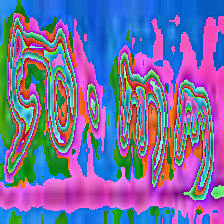

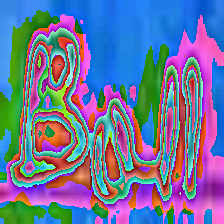

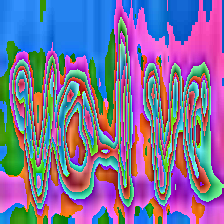

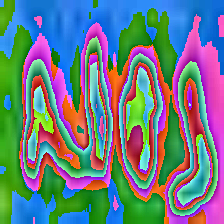

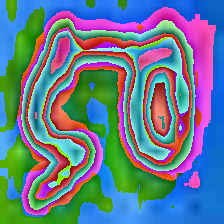

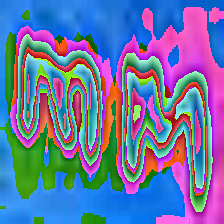

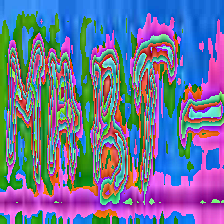

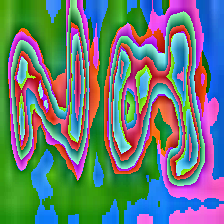

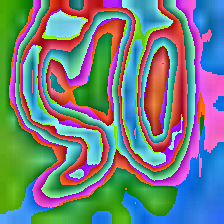

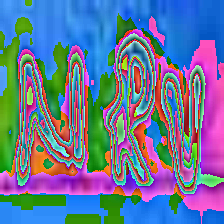

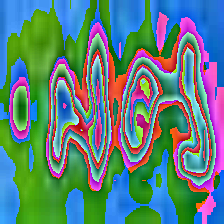

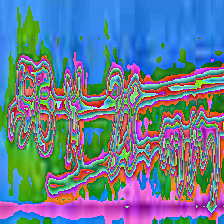

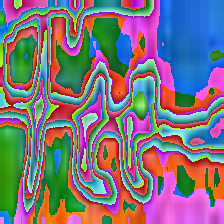

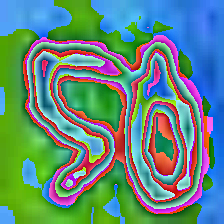

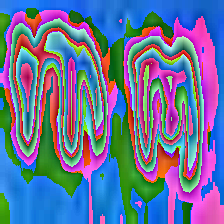

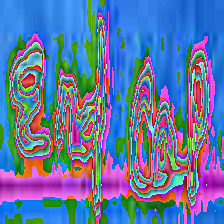

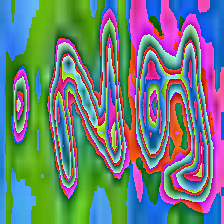

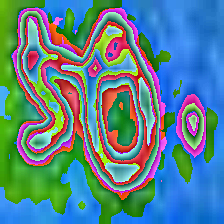

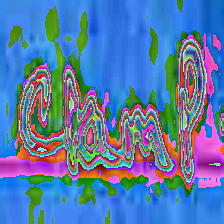

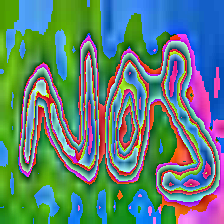

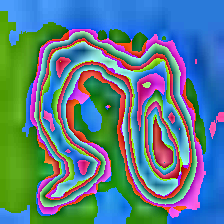

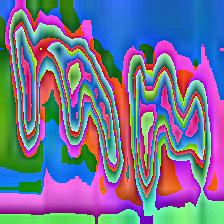

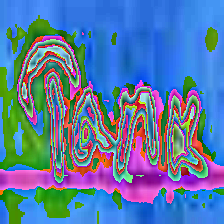

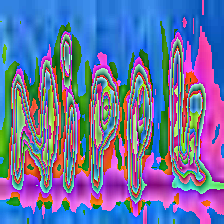

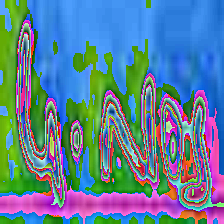

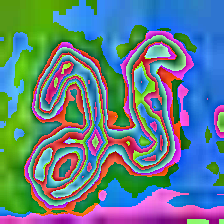

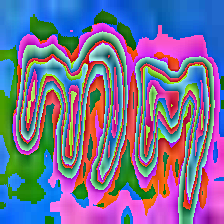

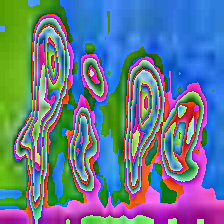

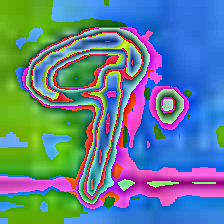

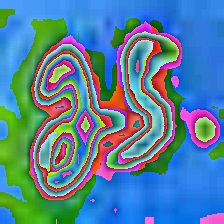

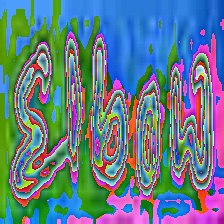

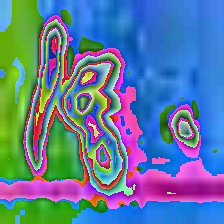

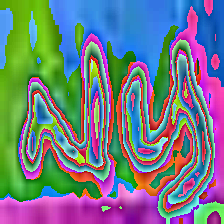

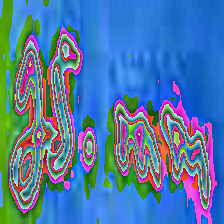

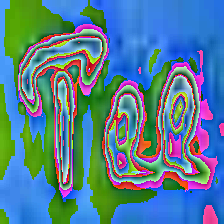

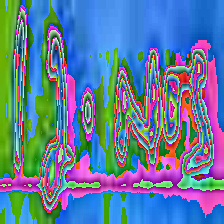

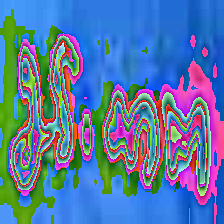

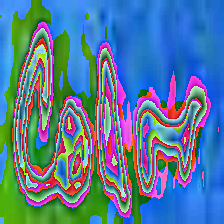

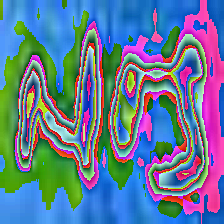

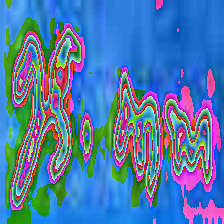

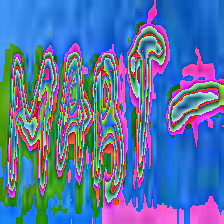

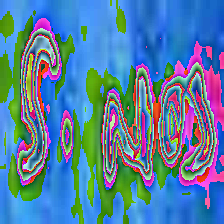

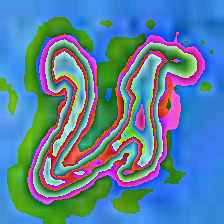

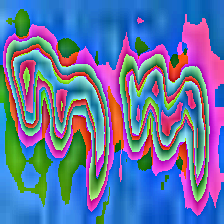

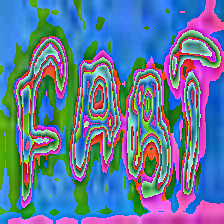

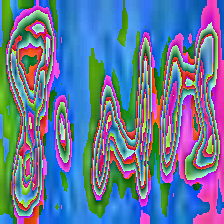

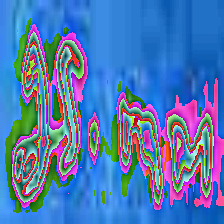

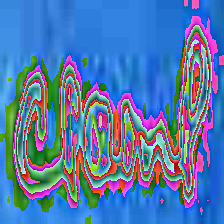

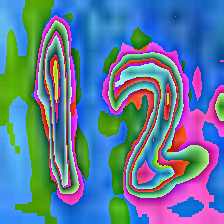

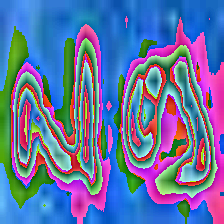

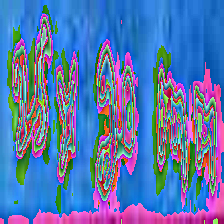

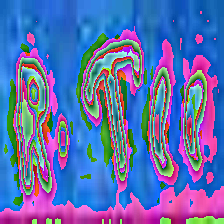

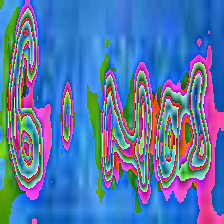

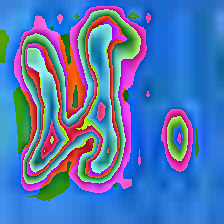

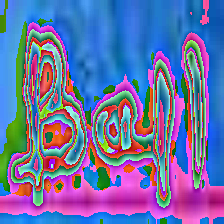

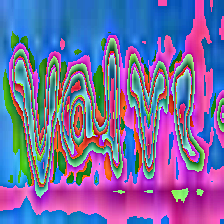

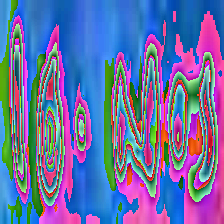

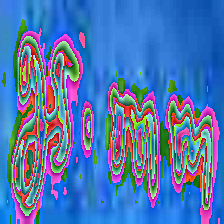

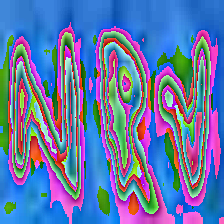

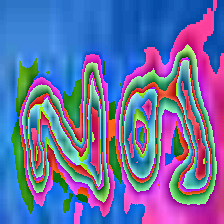

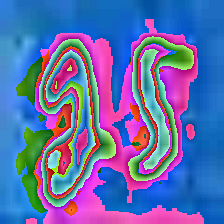

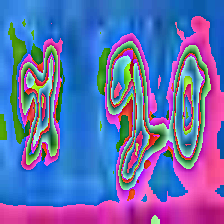

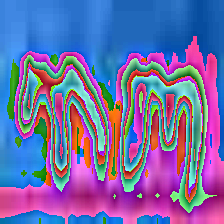

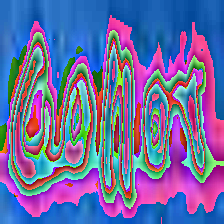

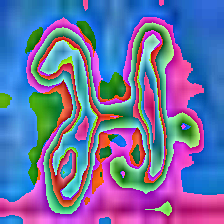

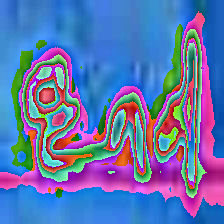

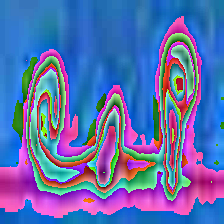

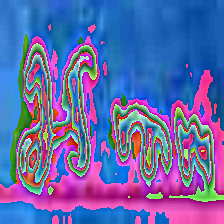

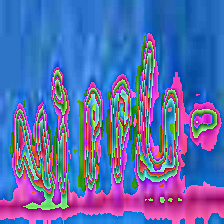

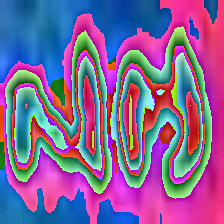

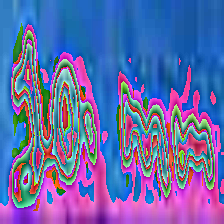

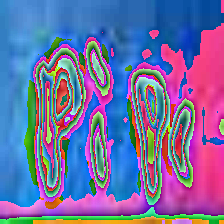

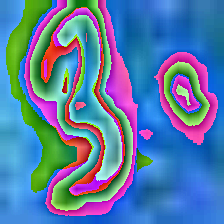

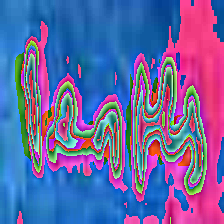

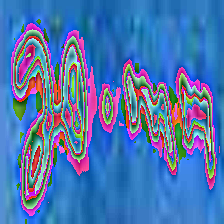

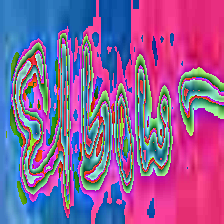

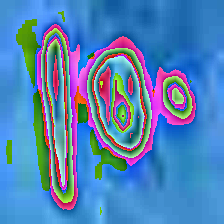

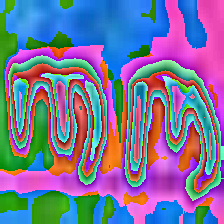

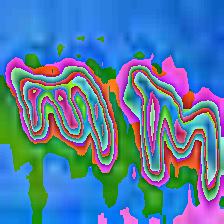

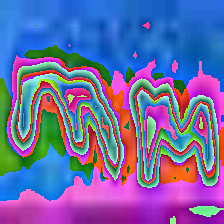

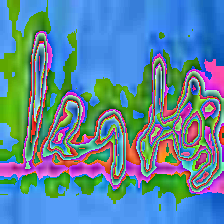

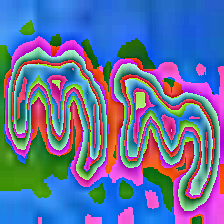

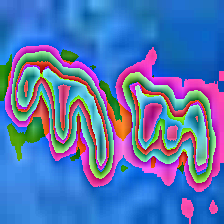

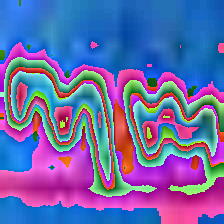

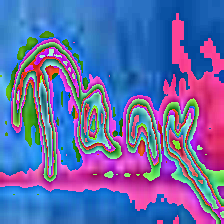

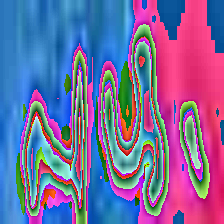

OCR process and data appending completed.


In [39]:
import easyocr
import cv2
import os
import torch
import json
import shutil
import numpy as np
from datetime import datetime
import torchvision.transforms as transforms
from torch import nn
from torchvision import models
from scipy.spatial import distance
from PIL import Image


# Function to calculate Euclidean distance between two vectors
def euclidean_distance(v1, v2):
    return np.linalg.norm(np.array(v1) - np.array(v2))

# Function to find the top closest vectors given preloaded data
def lookup(preloaded_data, vector, top_n=5):
    # Calculate distances and find the top closest vectors
    distances = [(euclidean_distance(vector, item['feature_vector']), item['text']) for item in preloaded_data]
    distances.sort(key=lambda x: x[0])
    closest_matches = distances[:top_n]
    return closest_matches

# Backup and load JSON data function
def backup_and_load_json(json_path):
    if os.path.isfile(json_path):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        backup_path = f"{json_path}_{timestamp}"
        #shutil.copy2(json_path, backup_path)
        #print(f"Backup of the JSON file created at: {backup_path}")

    # Load the JSON data
    if os.path.isfile(json_path):
        with open(json_path, 'r') as json_file:
            data = json.load(json_file)
    else:
        data = []

    return data

# Define paths
image_path = '/content/drive/MyDrive/OCR/samplepatch.jpg'
json_path = '/content/drive/MyDrive/OCR/ABMatch.sq'

# Load data once here
preloaded_data = backup_and_load_json(json_path)

# Check if the image file exists
if not os.path.isfile(image_path):
    raise FileNotFoundError(f"The image file {image_path} was not found.")

print(f"Image file found at: {image_path}")

# Backup the JSON file if it exists
if os.path.isfile(json_path):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_path = f"{json_path}_{timestamp}"
    #shutil.copy2(json_path, backup_path)
    #print(f"Backup of the JSON file created at: {backup_path}")

# Create a reader to do OCR.
reader = easyocr.Reader(['en'])

# Read the image.
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Unable to read the image from the path {image_path}.")

# Initialize the ResNet model and load pre-trained weights.
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

# Define a transformation to preprocess the image for ResNet
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Perform OCR on the image.
results = reader.readtext(image)

# Initialize an empty list to store data
data_to_append = []

# Process each detection and extract features
# Process each detection and extract features
for i, (bbox, text, prob) in enumerate(results):
    bbox = [(int(x), int(y)) for x, y in bbox]
    x1, y1 = bbox[0]
    x2, y2 = bbox[2]
    patch = image[y1:y2, x1:x2]
    patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    patch = preprocess(patch)
    patch = patch.unsqueeze(0)  # Add batch dimension

    # Extract features from the patch
    with torch.no_grad():
        features = resnet(patch)

    # Append data including the image_path
    data_to_append.append({
        'image_path': image_path,  # Store the image path
        'bbox': bbox,
        'text': text,
        'feature_vector': features.squeeze().tolist()
    })

    # Convert the patch to PIL Image and save it as a 224x224 image
    pil_image = transforms.ToPILImage()(patch.squeeze().cpu())
    pil_image = pil_image.resize((224, 224), Image.ANTIALIAS)
    image_save_path = f"patch_{i}.png"
    pil_image.save(image_save_path)
    display(pil_image)


# Append new data to preloaded data and save to JSON
preloaded_data.extend(data_to_append)
with open(json_path, 'w') as json_file:
    json.dump(preloaded_data, json_file, indent=4)

print("OCR process and data appending completed.")

# Example usage of the lookup function:
# vector_to_lookup = [0.5, 0.1, -0.2, ...]  # Replace with a real vector
# top_matches = lookup(preloaded_data, vector_to_lookup, top_n=5)
# print("Top matches:", top_matches)


In [27]:
# to verify the vector search back

# Load data once here for the lookup
preloaded_data = backup_and_load_json(json_path)

# Path for the new image to check
check_image_path = '/content/drive/MyDrive/OCR/IMG-20230902-WA0045.jpg'

# Check if the new image file exists
if not os.path.isfile(check_image_path):
    raise FileNotFoundError(f"The image file {check_image_path} was not found.")

print(f"New image file found at: {check_image_path}")

# Read the new image.
check_image = cv2.imread(check_image_path)
if check_image is None:
    raise ValueError(f"Unable to read the image from the path {check_image_path}.")

# Perform OCR on the new image to detect text regions.
check_results = reader.readtext(check_image)

# Initialize an empty list to store data for the new image
check_data_to_append = []

# Mark regions of detected text in the new image, get vectors and use lookup
for i, (bbox, text, prob) in enumerate(check_results):
    # Mark the detected text region on the image
    bbox_points = [(int(x), int(y)) for x, y in bbox]
    cv2.rectangle(check_image, bbox_points[0], bbox_points[2], (0, 255, 0), 2)

    # Extract the image patch from the detected text area
    x1, y1 = bbox_points[0]
    x2, y2 = bbox_points[2]
    patch = check_image[y1:y2, x1:x2]
    patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    patch = preprocess(patch)
    patch = patch.unsqueeze(0)  # Add batch dimension

    # Get the feature vector for the patch
    with torch.no_grad():
        features = resnet(patch)

    # Store data for the new image (optional)
    check_data_to_append.append({
        'bbox': bbox_points,
        'text': text,
        'feature_vector': features.squeeze().tolist()
 #       'feature_vector': features.squeeze().tolist()
    })

    # Use the lookup function to find the closest matches for the vector
    vector_to_lookup = features.squeeze().tolist()
    top_matches = lookup(preloaded_data, vector_to_lookup, top_n=5)
    print(f"Top matches for detected text '{text}':", top_matches)

# Optionally, save the marked image to check the regions
marked_image_path = check_image_path.replace('.jpg', '_marked.jpg')
cv2.imwrite(marked_image_path, check_image)
print(f"Marked image saved at: {marked_image_path}")

# ... [The rest of your code] ...


New image file found at: /content/drive/MyDrive/OCR/IMG-20230902-WA0045.jpg
Top matches for detected text '12': [(11.096157387033704, 'P i pe'), (11.096157387033704, 'P i pe'), (11.096157387033704, 'P i pe'), (11.096157387033704, 'P i pe'), (11.096157387033704, 'P i pe')]
Top matches for detected text 'pir': [(10.141234160065705, '19X 3'), (10.218334553913353, 'nos'), (10.227065137255535, 'S noS'), (10.323805244089035, '3 Pcs'), (10.42617582889665, 'nos')]
Top matches for detected text '86'': [(11.034797562633681, '6 Pss'), (11.036896554573318, '40'), (11.036896554573318, '40'), (11.036896554573318, '40'), (11.036896554573318, '40')]
Top matches for detected text 'pr': [(9.64603093840502, 'nos'), (9.7540108000378, '19X 3'), (10.138223751697188, 'Ispes'), (10.237736479054588, 'Pcs'), (10.242368031448606, '3 Aus')]
Top matches for detected text 'pn': [(11.580433532499807, 'Pvc'), (11.804969127091391, 'Pvc'), (11.995944036635619, 'no$'), (12.563256085212704, 'prs'), (12.84700228506746, 'P

In [ ]:
import easyocr
import cv2
import os
import torch
import json
import shutil
import numpy as np
from datetime import datetime
import torchvision.transforms as transforms
from torch import nn
from torchvision import models
from scipy.spatial import distance

# Function to calculate Euclidean distance between two vectors
def euclidean_distance(v1, v2):
    return np.linalg.norm(np.array(v1) - np.array(v2))

# Function to find the top closest vectors given preloaded data
def lookup(preloaded_data, vector, top_n=5):
    # Calculate distances and find the top closest vectors
    distances = [(euclidean_distance(vector, item['feature_vector']), item['text']) for item in preloaded_data]
    distances.sort(key=lambda x: x[0])
    closest_matches = distances[:top_n]
    return closest_matches

# Backup and load JSON data function
def backup_and_load_json(json_path):
    if os.path.isfile(json_path):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        backup_path = f"{json_path}_{timestamp}"
        shutil.copy2(json_path, backup_path)
        print(f"Backup of the JSON file created at: {backup_path}")

    # Load the JSON data
    if os.path.isfile(json_path):
        with open(json_path, 'r') as json_file:
            data = json.load(json_file)
    else:
        data = []

    return data

# Define paths
image_path = '/content/drive/MyDrive/OCR/1 (2).jpg'
json_path = '/content/drive/MyDrive/OCR/ABMatch.sq'

# Load data once here
preloaded_data = backup_and_load_json(json_path)

# Check if the image file exists
if not os.path.isfile(image_path):
    raise FileNotFoundError(f"The image file {image_path} was not found.")

print(f"Image file found at: {image_path}")

# Backup the JSON file if it exists
if os.path.isfile(json_path):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_path = f"{json_path}_{timestamp}"
    shutil.copy2(json_path, backup_path)
    print(f"Backup of the JSON file created at: {backup_path}")

# Create a reader to do OCR.
reader = easyocr.Reader(['en'])

# Read the image.
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Unable to read the image from the path {image_path}.")

# Initialize the VGG16 model and load pre-trained weights.
vgg16 = models.vgg16(pretrained=True)
vgg16.features = nn.Sequential(*list(vgg16.features.children())[:-1])
vgg16.eval()

# Define a transformation to preprocess the image for VGG16
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Perform OCR on the image.
results = reader.readtext(image)

# Initialize an empty list to store data
data_to_append = []

# Process each detection and extract features
for i, (bbox, text, prob) in enumerate(results):
    bbox = [(int(x), int(y)) for x, y in bbox]
    x1, y1 = bbox[0]
    x2, y2 = bbox[2]
    patch = image[y1:y2, x1:x2]
    patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    patch = preprocess(patch)
    patch = patch.unsqueeze(0)  # Add batch dimension

    # Extract features from the patch
    with torch.no_grad():
        features = vgg16(patch)

    # Append data including the image_path
    data_to_append.append({
        'image_path': image_path,  # Store the image path
        'bbox': bbox,
        'text': text,
        'feature_vector': features.squeeze().tolist()
    })

# Append new data to preloaded data and save to JSON
preloaded_data.extend(data_to_append)
with open(json_path, 'w') as json_file:
    json.dump(preloaded_data, json_file, indent=4)

print("OCR process and data appending completed.")

# Example usage of the lookup function:
# vector_to_lookup = [0.5, 0.1, -0.2, ...]  # Replace with a real vector
# top_matches = lookup(preloaded_data, vector_to_lookup, top_n=5)
# print("Top matches:", top_matches)


In [ ]:
# Path for the new image to check
check_image_path = '/content/drive/MyDrive/OCR/1.jpg'

# Check if the new image file exists
if not os.path.isfile(check_image_path):
    raise FileNotFoundError(f"The image file {check_image_path} was not found.")

print(f"New image file found at: {check_image_path}")

# Read the new image.
check_image = cv2.imread(check_image_path)
if check_image is None:
    raise ValueError(f"Unable to read the image from the path {check_image_path}.")

# Perform OCR on the new image to detect text regions.
check_results = reader.readtext(check_image)

# Initialize an empty list to store data for the new image
check_data_to_append = []

# Mark regions of detected text in the new image and use lookup
for i, (bbox, text, prob) in enumerate(check_results):
    # Mark the detected text region on the image
    bbox_points = [(int(x), int(y)) for x, y in bbox]
    cv2.rectangle(check_image, bbox_points[0], bbox_points[2], (0, 255, 0), 2)

    # Extract the image patch from the detected text area
    x1, y1 = bbox_points[0]
    x2, y2 = bbox_points[2]
    patch = check_image[y1:y2, x1:x2]
    patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    patch = preprocess(patch)
    patch = patch.unsqueeze(0)  # Add batch dimension

    # Get the feature vector for the patch using VGG16
    with torch.no_grad():
        features = vgg16(patch)

    # Store data for the new image (optional)
    check_data_to_append.append({
        'bbox': bbox_points,
        'text': text,
        'feature_vector': features.squeeze().tolist()
    })

    # Use the lookup function to find the closest matches for the vector
    vector_to_lookup = features.squeeze().tolist()
    top_matches = lookup(preloaded_data, vector_to_lookup, top_n=5)
    print(f"Top matches for detected text '{text}':", top_matches)

# Optionally, save the marked image to check the regions
marked_image_path = check_image_path.replace('.jpg', '_marked.jpg')
cv2.imwrite(marked_image_path, check_image)
print(f"Marked image saved at: {marked_image_path}")

# ... [The rest of your code] ...


In [40]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [7]:
!rm

total 705680
-rw------- 1 root root   2111462 Jun 23  2021  20171123_224719.jpg
-rw------- 1 root root   2037383 Jun 23  2021  20171123_224727.jpg
-rw------- 1 root root       155 Jun  6  2015  AM.gmap
drwx------ 2 root root      4096 Apr 24  2022  assets
-rw------- 1 root root       171 May 12  2023 'can you show me a example of a box plot in .svg format.gdoc'
-rw------- 1 root root       171 Jun 11 05:54 'can you swap the rows and columns of the above table.gsheet'
drwx------ 2 root root      4096 Jul  3 11:16  cli
drwx------ 2 root root      4096 Jul 12 11:48  cli2
drwx------ 2 root root      4096 Dec 30  2020 'Colab Notebooks'
-rw------- 1 root root 213912943 Nov  2 14:58  corpus.zip
-rw------- 1 root root    333696 Oct  9  2016  D24p5J.json
-rw------- 1 root root     11980 Mar  2  2023 'Data Catalogue.xlsx'
-rw------- 1 root root   9000881 Apr 22  2022  DISCO21.csv
-rw------- 1 root root   9028799 Apr 22  2022  DISCO22.csv
-rw------- 1 root root   9475386 Apr 22  2022  DISCO23.csv

In [66]:
ls -l

total 285278
-rw------- 1 root root  2111462 Jun 23  2021  20171123_224719.jpg
-rw------- 1 root root  2037383 Jun 23  2021  20171123_224727.jpg
-rw------- 1 root root      155 Jun  6  2015  AM.gmap
drwx------ 2 root root     4096 Apr 24  2022  assets/
-rw------- 1 root root      171 May 12  2023 'can you show me a example of a box plot in .svg format.gdoc'
-rw------- 1 root root      171 Jun 11 05:54 'can you swap the rows and columns of the above table.gsheet'
drwx------ 3 root root     4096 Nov 11 08:30 'Colab Notebooks'/
-rw------- 1 root root   333696 Oct  9  2016  D24p5J.json
-rw------- 1 root root    11980 Mar  2  2023 'Data Catalogue.xlsx'
-rw------- 1 root root  9000881 Apr 22  2022  DISCO21.csv
-rw------- 1 root root  9028799 Apr 22  2022  DISCO22.csv
-rw------- 1 root root  9475386 Apr 22  2022  DISCO23.csv
-rw------- 1 root root    10484 Apr 23  2022  DISCO23r.csv
-rw------- 1 root root      260 Apr 23  2022  DISCO23rr.csv
-rw------- 1 root root 11727742 Apr 24  2022  DISCO

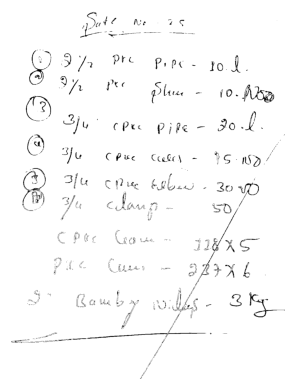

True

In [49]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image in its original color format
image_path = '/content/drive/MyDrive/OCR/1.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Convert the image to the HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the range of blue color in HSV
# These values may need to be adjusted for different shades of blue ink
lower_blue = np.array([100, 60, 60])
upper_blue = np.array([140, 255, 255])

# Create a mask to isolate the blue ink
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Bitwise-AND the mask with the original image to extract the blue ink
isolated_text = cv2.bitwise_and(image, image, mask=mask)

# Convert the isolated text to grayscale
gray_text = cv2.cvtColor(isolated_text, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create a binary image
_, binary_text = cv2.threshold(gray_text, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Show the result
plt.imshow(binary_text, cmap='gray')
plt.axis('off')  # Hide axis labels and ticks
plt.show()

# Save the result if needed
output_path = '/content/drive/MyDrive/OCR/output_image_path.jpg'  # Replace with your desired output path
cv2.imwrite(output_path, binary_text)


In [44]:
cd /content/drive/MyDrive/OCR

/content/drive/MyDrive/OCR


In [48]:
ls -l /content/drive/MyDrive/output_image_path.jpg

-rw------- 1 root root 219891 Nov 11 09:53 /content/drive/MyDrive/output_image_path.jpg


In [36]:
cd /content/drive/MyDrive/huggingface_cache/

/content/drive/MyDrive/huggingface_cache
